In [111]:
import numpy as np
import pandas as pd
import segyio
import matplotlib.pyplot as plt
import os
from ukpgks import signal as usignal
import random
from ukpgks import wiggle
import fcmeans as fcm
import RSSPython as rs

In [9]:
# make simple synthetic
ns = 50        # number of traces
t1,t2 = 0.4,2  # labels range
nt = 3001      # time axis

train_data   = np.zeros([ns,nt])
train_labels = np.zeros(ns)
x = np.arange(0,50)
np.random.seed(42) # to repeat experiment
def create_model(train_data,t1,t2):
    mu, sigma = 0, 0.01 # mean and standard deviation of noise
    dt = 0.001
    tmax = .8
    t = np.arange(0,tmax+dt,dt)
    y = np.sin(80*np.pi*t)*np.exp(-10*t) # signal
    ny = y.shape[0]
    
    for i in range(train_data.shape[0]):
        mu, sigma = 0, np.random.uniform(0.001, 0.015) # mean and standard deviation
        s = np.random.normal(mu, sigma, 3001)          # 3001 --> 3 sec legth 
        ts = np.round(np.random.uniform(0.4, 2.0),1)
        idx = int(ts/dt)
        s[idx:idx+ny] = s[idx:idx+ny] + y               # add signal and noise
        train_data[i,:] = s
        train_labels[i] = ts
    return train_data,train_labels

train_data,train_labels = create_model(train_data,t1,t2)

Text(0, 0.5, 'Amplitude')

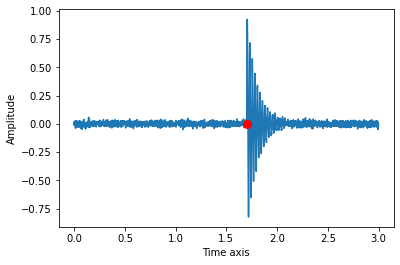

In [110]:
t = np.arange(0,3.0+dt,dt)
#plot a random signle trace
n = np.random.randint(low=0,high=49)
plt.plot(t,train_data[n,:])
plt.plot(train_labels[n],0,'ro',ms=8)
plt.xlabel('Time axis');plt.ylabel('Amplitude')

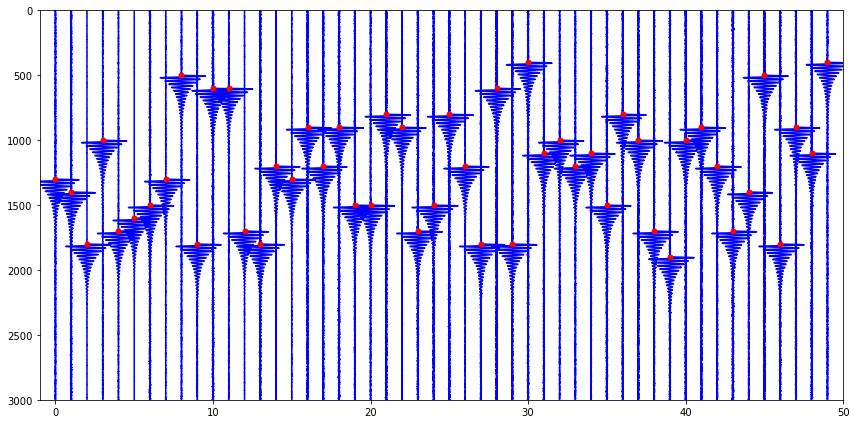

In [106]:
plt.figure(figsize=(12,6))
wiggle.wiggle(train_data.T,color='b')
plt.plot(x,train_labels/0.001,'r.',ms=10)
plt.tight_layout()

In [63]:
# define feature functions
def classic_sta_lta_py(a, nsta, nlta):
    """
    (copied from obspy.signal)
    short-term-average long-term-average method STA/LTA
    Computes the standard STA/LTA from a array a. 
    STA and LTA are defined in samples.

    :type a: NumPy :class: ~numpy.ndarray
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: STA/LTA relation
    """
    # The cumulative sum can be exploited to calculate a moving average (the
    # cumsum function is quite efficient)
    sta = np.cumsum(a ** 2, dtype=np.float64)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[nsta:] = sta[nsta:] - sta[:-nsta]
    sta /= nsta
    lta[nlta:] = lta[nlta:] - lta[:-nlta]
    lta /= nlta

    # Pad zeros
    sta[:nlta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def mean(a,w):
    m = np.cumsum(a**2)
    m[w:] = m[w:] - m[:-w]
    m /= w
    return m

def power(a,w):
    m = np.cumsum(a**2)
    m[w:] = m[w:] - m[:-w]
    return m

Text(0, 0.5, 'Labels')

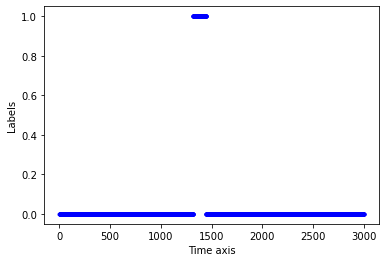

In [102]:
# train example one trace
a = train_data[0,:]
a_m = mean(a,100)
a_p = power(a,100)
a_sl = classic_sta_lta_py(a,100,600)
X = np.array([a_m,a_p,a_sl])
X = X.T
model = fcm.FCM(n_clusters=2)
model.fit(X)
s= model.predict(X)
#plt.plot(a_m)
#plt.plot(a_p)
#plt.plot(a_sl)
plt.plot(s,'b.')
plt.xlabel('Time axis');plt.ylabel('Labels')

In [103]:
# create  DataFrame to store y_true and y_pred
df = pd.DataFrame(columns=['y_true'])
df['y_true'] = train_labels/dt
df['y_true'] = df['y_true'].astype(int)
model = fcm.FCM(n_clusters=2)
for trace in range(train_data.shape[0]):
    a = train_data[trace,:]
    a_m = mean(a,100)
    a_p = power(a,100)
    a_sl = classic_sta_lta_py(a,100,600)
    # feature arrays
    X = np.array([a_m,a_p,a_sl])
    X = X.T
    
    model.fit(X)
    s= model.predict(X)
    y_pred = np.argmax(s)
    if y_pred==0:
        y_pred = np.argmin(s)
    df.loc[trace,'y_pred'] = y_pred
    

In [104]:
df.head()

,y_true,y_pred
0,1300,1318.0
1,1399,1417.0
2,1800,1818.0
3,1000,1018.0
4,1700,1718.0


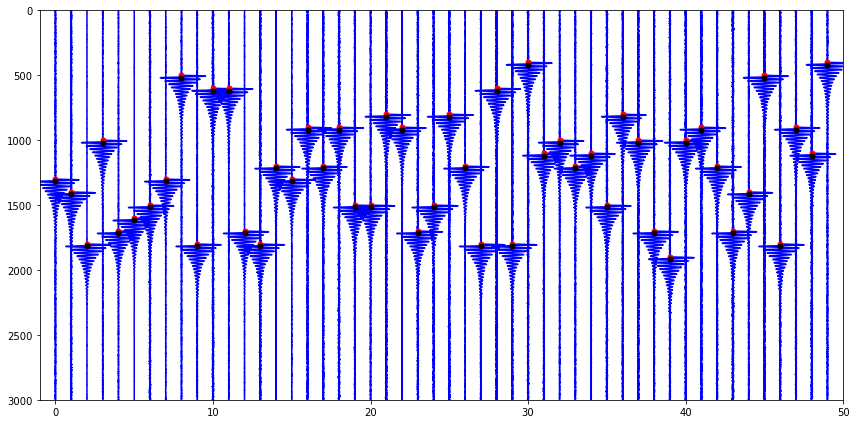

In [105]:
plt.figure(figsize=(12,6))
wiggle.wiggle(train_data.T,color='b')
plt.plot(x,train_labels/0.001,'r.',ms=10)
plt.plot(x,df.y_pred,'k.',ms=10)
plt.tight_layout()

In [112]:
rss = rs.RSSdata()
rss.read('../../tmp/d.rss')
data = rss.data.squeeze()
data.shape

(1251, 641)

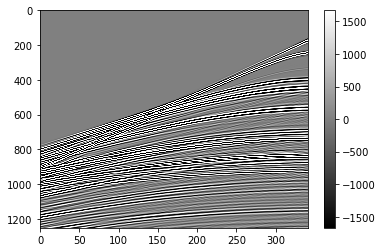

In [119]:
v= np.percentile(data,90)
shot = data[:,300:].T
plt.imshow(shot.T,aspect='auto',cmap='gray',vmax=v,vmin=-v)
plt.colorbar()

Text(0, 0.5, 'Labels')

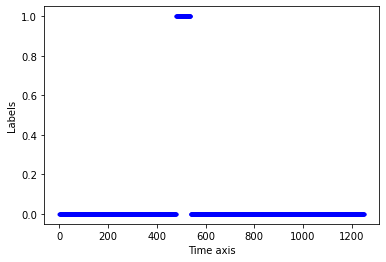

In [126]:
# train example one trace
a = shot[200,:]
a_m = mean(a,60)
a_p = power(a,60)
a_sl = classic_sta_lta_py(a,60,400)
X = np.array([a_m,a_p,a_sl])
X = X.T

#plt.plot(a)

#plt.plot(a_m)
#plt.plot(a_p)
#plt.plot(a_sl)

model = fcm.FCM(n_clusters=2)
model.fit(X)
s= model.predict(X)

plt.plot(s,'b.')
plt.xlabel('Time axis');plt.ylabel('Labels')


In [144]:
df = pd.DataFrame(columns=['y_pred'])
model = fcm.FCM(n_clusters=2)
sta = 40
lta = 200
for trace in range(shot.shape[0]):
    a = shot[trace,:]
    a_m = mean(a,sta)
    a_p = power(a,sta)
    #a_sl = classic_sta_lta_py(a,sta,lta)
    # feature arrays
    #X = np.array([a_m,a_p,a_sl])
    X = np.array([a_m,a_p])
    X = X.T
    
    model.fit(X)
    s= model.predict(X)
    y_pred = np.argmax(s)
    if y_pred==0:
        y_pred = np.argmin(s)
    df.loc[trace,'y_pred'] = y_pred

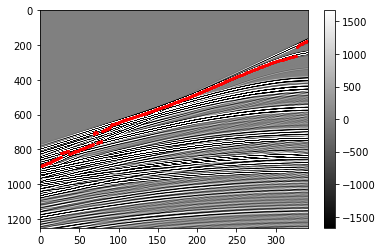

In [145]:
v= np.percentile(data,90)
shot = data[:,300:].T
plt.imshow(shot.T,aspect='auto',cmap='gray',vmax=v,vmin=-v)
x = np.arange(shot.shape[0])
plt.plot(x,df['y_pred'],'r.',ms=4)
plt.colorbar()

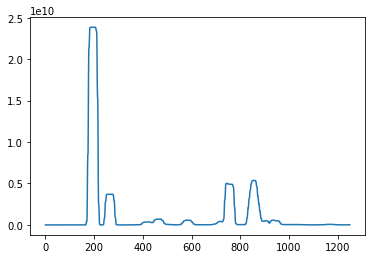

In [146]:
plt.plot(a_p)